# Paragraph-Level Coherence in Dostoevsky

This notebook analyzes how paragraph-level semantic coherence behaves in two novels by Fyodor Dostoevsky:

- **Crime and Punishment**
- **The Brothers Karamazov**

The goal is to connect paragraph coherence to the research question:

> **How do emotional language patterns and paragraph-level coherence reflect the psychological transition from isolation to engagement in _Crime and Punishment_ and _The Brothers Karamazov_?**

In this notebook we will:

- load the full texts of both novels  
- split them into paragraphs and then into sentences  
- compute **embedding-based coherence** for each paragraph using a sentence-level transformer model  
- compare coherence patterns across the two books  
- prepare summary statistics and visualizations that can be used in the final paper and presentation

Later in the notebook, we will also derive **character-focused coherence views** (e.g. paragraphs strongly associated with Raskolnikov) as a refinement of the global coherence analysis.


In [1]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Automatically save every figure that gets shown
old_show = plt.show

def custom_show(*args, **kwargs):
    # create unique filename for each saved plot
    fname = f"figures/plot_{plt.gcf().number}.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    old_show(*args, **kwargs)

plt.show = custom_show


In [2]:
import re
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Sentence-level embedding model (small but good quality)
model = SentenceTransformer("all-MiniLM-L6-v2")


def load_book(filepath: str) -> str:
    """
    Load a plain-text novel from disk and remove obvious Project Gutenberg
    headers/footers if they are present.

    The function returns a single raw string containing the main body of the text.
    """
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()

    # (Optional) very simple cleaning of typical Gutenberg markers.
    # If your files are already pre-cleaned, you can keep this as a no-op,
    # or adjust the markers to your own files.
    start_match = re.search(r"\*\*\* START OF.*?\*\*\*", text)
    if start_match:
        text = text[start_match.end() :]

    end_match = re.search(r"\*\*\* END OF.*?\*\*\*", text)
    if end_match:
        text = text[: end_match.start()]

    # Fallback: older Gutenberg footer style
    if "End of Project Gutenberg" in text:
        end = text.find("End of Project Gutenberg")
        text = text[:end]

    return text.strip()


# -------------------------------------------------------------------
# Load the two Dostoevsky novels used in the project
# -------------------------------------------------------------------
crime_path = "../data/Crime-punishment.txt"
brothers_path = "../data/The-Brotherskaramazov.txt"

crime_text = load_book(crime_path)
brothers_karamazov_text = load_book(brothers_path)

print(f"Crime and Punishment characters: {len(crime_text):,}")
print(f"The Brothers Karamazov characters: {len(brothers_karamazov_text):,}")


c:\Users\moham\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crime and Punishment characters: 1,224,428
The Brothers Karamazov characters: 1,954,860


In [3]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """
    Split raw text into paragraphs using blank lines as boundaries.

    Very short paragraphs (e.g. chapter titles) are filtered out by `min_words`.
    """
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    raw_paras = re.split(r"\n\s*\n+", text)

    paragraphs = []
    for p in raw_paras:
        cleaned = re.sub(r"\s+", " ", p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paragraphs.append(cleaned)

    return paragraphs


def sentence_split(paragraph: str) -> List[str]:
    """
    Very simple sentence splitter for a single paragraph.

    For this project we do not need perfect sentence segmentation; we just need
    stable chunks for computing paragraph-internal coherence.
    """
    # Split on ., !, ? and keep non-empty fragments
    pieces = re.split(r"(?<=[.!?])\s+", paragraph)
    sentences = [s.strip() for s in pieces if len(s.strip().split()) > 2]
    return sentences


def cosine_similarity(u: np.ndarray, v: np.ndarray) -> float:
    """Cosine similarity between two embedding vectors."""
    denom = (np.linalg.norm(u) * np.linalg.norm(v)) or 1e-9
    return float(np.dot(u, v) / denom)


def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[List[str], List[float], List[int]]:
    """
    Compute embedding-based coherence for each paragraph and return only the
    paragraphs that are actually used (>= 2 sentences).

    Returns:
    - used_paragraphs: list of paragraphs that had at least two sentences
    - scores: list of coherence scores (one per used paragraph)
    - lengths: list of paragraph lengths in words (one per used paragraph)
    """
    used_paragraphs = []
    scores = []
    lengths = []

    for para in paragraphs:
        sents = sentence_split(para)
        if len(sents) < 2:
            continue

        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]

        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
        used_paragraphs.append(para)

    return used_paragraphs, scores, lengths

# -------------------------------------------------------------------
# Compute paragraph coherence for both novels
# -------------------------------------------------------------------
crime_paras = split_into_paragraphs(crime_text)
brothers_paras = split_into_paragraphs(brothers_karamazov_text)

crime_paras = split_into_paragraphs(crime_text)
brothers_paras = split_into_paragraphs(brothers_karamazov_text)

crime_paras_used, c_scores, c_lengths = paragraph_coherence_embeddings(crime_paras)
brothers_paras_used, b_scores, b_lengths = paragraph_coherence_embeddings(brothers_paras)

print(f"Crime and Punishment mean coherence: {np.mean(c_scores):.3f}")
print(f"The Brothers Karamazov mean coherence: {np.mean(b_scores):.3f}")


Crime and Punishment mean coherence: 0.528
The Brothers Karamazov mean coherence: 0.693


In [4]:
import pandas as pd

def build_paragraph_df(paragraphs, scores, lengths, book_label: str) -> pd.DataFrame:
    df = pd.DataFrame(
        {
            "paragraph": paragraphs,
            "coherence": scores,
            "length": lengths,
        }
    )
    df["book"] = book_label
    df["position_norm"] = np.linspace(0, 1, len(df))
    return df

crime_df = build_paragraph_df(crime_paras_used, c_scores, c_lengths, "Crime and Punishment")
brothers_df = build_paragraph_df(brothers_paras_used, b_scores, b_lengths, "The Brothers Karamazov")

crime_df.head(), brothers_df.head()


(                                           paragraph  coherence  length  \
 0  How could a nineteenth-century Russian novel s...   0.713099     178   
 1  fear so much — crimes which themselves spawn c...   0.535082     242   
 2  Literature in the 1840s, he was convicted of s...   0.563174     233   
 3  story of a university dropout, Raskolnikov, wh...   0.644090     234   
 4  the reactions of his friends and family not on...   0.669567     250   
 
                    book  position_norm  
 0  Crime and Punishment       0.000000  
 1  Crime and Punishment       0.001163  
 2  Crime and Punishment       0.002326  
 3  Crime and Punishment       0.003488  
 4  Crime and Punishment       0.004651  ,
                                            paragraph  coherence  length  \
 0  Alexey Fyodorovitch Karamazov was the third so...   0.667412     215   
 1  He was married twice, and had three sons, the ...   0.591962     451   
 2  Immediately after the elopement Adelaïda Ivano...   0.632

## 1. Global paragraph coherence in both novels

We first compare **overall paragraph-level coherence** between the two novels.

For each paragraph we computed:

- a sentence-level embedding for each sentence,
- a centroid embedding for the paragraph,
- the mean cosine similarity of sentences to this centroid.

Higher scores indicate that the sentences in a paragraph are semantically tightly clustered;  
lower scores indicate more fragmented or internally heterogeneous paragraphs.

In this section we look at the **distribution** of these coherence scores in:

- _Crime and Punishment_  
- _The Brothers Karamazov_


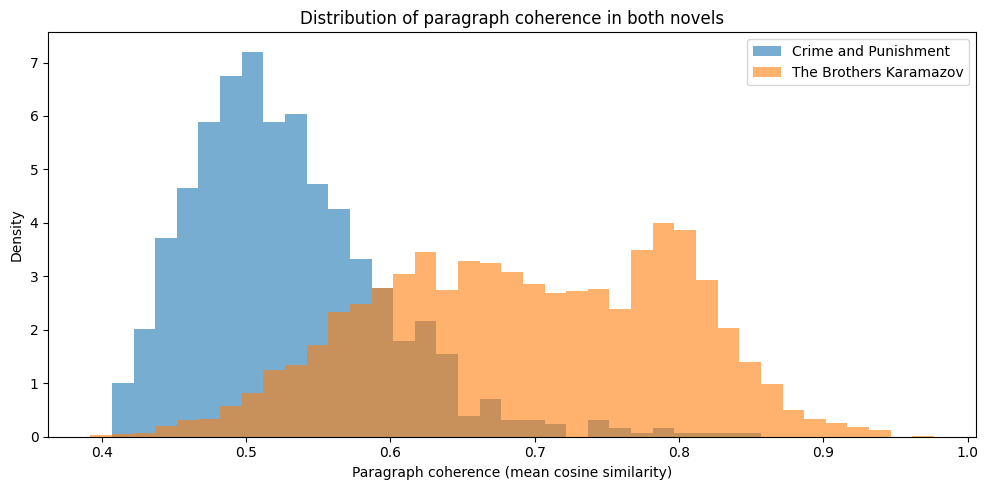

C:\Users\moham\AppData\Local\Temp\ipykernel_13976\2298407913.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([c_scores, b_scores], labels=["Crime and Punishment", "The Brothers Karamazov"])


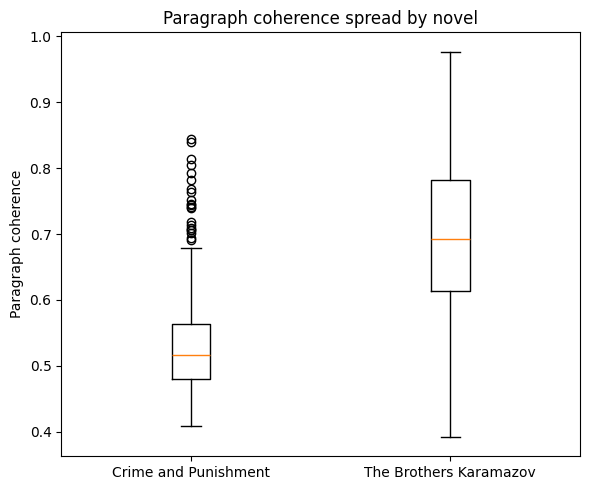

In [5]:
import matplotlib.pyplot as plt

def plot_coherence_distribution(c_scores, b_scores):
    plt.figure(figsize=(10, 5))
    bins = np.linspace(
        min(min(c_scores), min(b_scores)),
        max(max(c_scores), max(b_scores)),
        40,
    )

    plt.hist(c_scores, bins=bins, alpha=0.6, label="Crime and Punishment", density=True)
    plt.hist(b_scores, bins=bins, alpha=0.6, label="The Brothers Karamazov", density=True)

    plt.xlabel("Paragraph coherence (mean cosine similarity)")
    plt.ylabel("Density")
    plt.title("Distribution of paragraph coherence in both novels")
    plt.legend()
    plt.tight_layout()
    plt.show()


def boxplot_coherence(c_scores, b_scores):
    plt.figure(figsize=(6, 5))
    plt.boxplot([c_scores, b_scores], labels=["Crime and Punishment", "The Brothers Karamazov"])
    plt.ylabel("Paragraph coherence")
    plt.title("Paragraph coherence spread by novel")
    plt.tight_layout()
    plt.show()


plot_coherence_distribution(c_scores, b_scores)
boxplot_coherence(c_scores, b_scores)


## 2. Coherence over the course of each novel

To connect coherence to the **psychological transition from isolation to engagement**,  
we also need to see how coherence behaves **over narrative time**.

We therefore:

- index paragraphs in reading order,
- normalise the position of each paragraph to the range \[0, 1] (start → end),
- plot paragraph coherence as a function of narrative position,
- apply a simple rolling mean to see broader trends rather than individual noise.

This helps us answer questions such as:

- Are early sections (associated with isolation and inner turmoil) less coherent?
- Do later sections (associated with moral reconciliation and engagement) become more coherent?


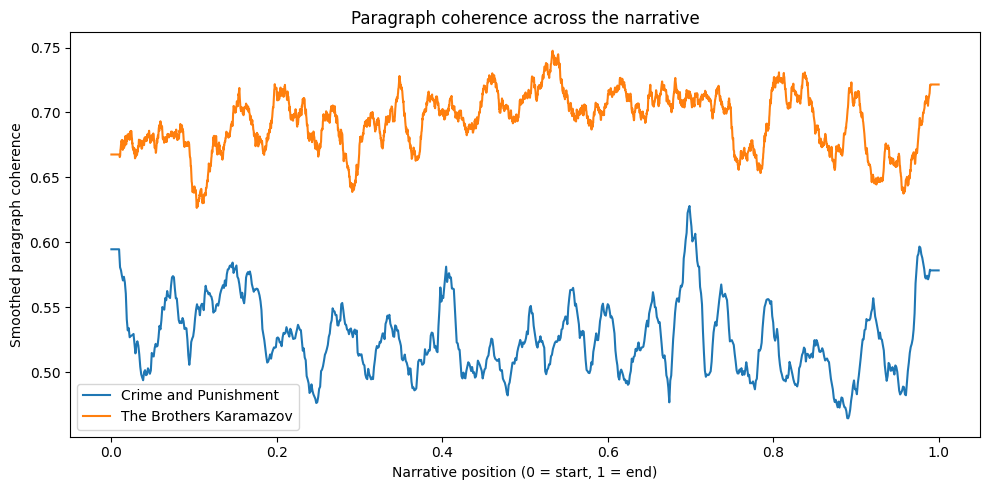

In [6]:
def rolling_mean(values, window: int = 25):
    values = np.asarray(values)
    if window <= 1 or window > len(values):
        return values
    cumsum = np.cumsum(np.insert(values, 0, 0))
    smoothed = (cumsum[window:] - cumsum[:-window]) / float(window)
    # pad to original length
    pad_left = window // 2
    pad_right = len(values) - len(smoothed) - pad_left
    return np.pad(smoothed, (pad_left, pad_right), mode="edge")


def plot_coherence_over_position(scores, label, color=None):
    n = len(scores)
    x = np.linspace(0, 1, n)  # normalised narrative position
    y_smooth = rolling_mean(scores, window=max(15, n // 50))

    plt.plot(x, y_smooth, label=label)


plt.figure(figsize=(10, 5))
plot_coherence_over_position(c_scores, "Crime and Punishment")
plot_coherence_over_position(b_scores, "The Brothers Karamazov")

plt.xlabel("Narrative position (0 = start, 1 = end)")
plt.ylabel("Smoothed paragraph coherence")
plt.title("Paragraph coherence across the narrative")
plt.legend()
plt.tight_layout()
plt.show()


## 3. Coherence and paragraph length

Before interpreting coherence as a purely psychological signal, we need to check
whether it is trivially explained by **paragraph length** (very short vs very long paragraphs).

Here we inspect the relationship between:

- paragraph length in words
- paragraph coherence score

for both novels.


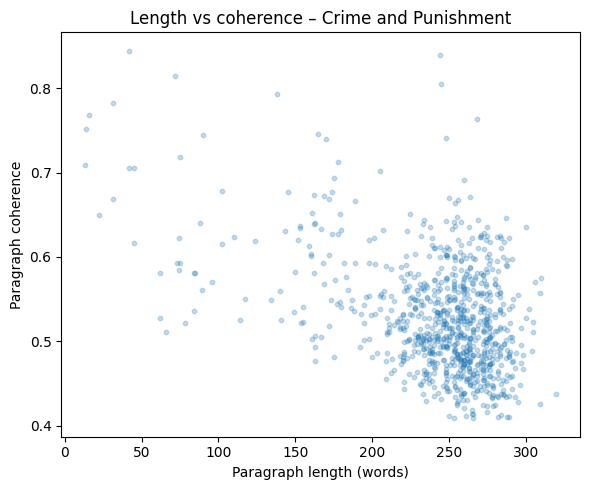

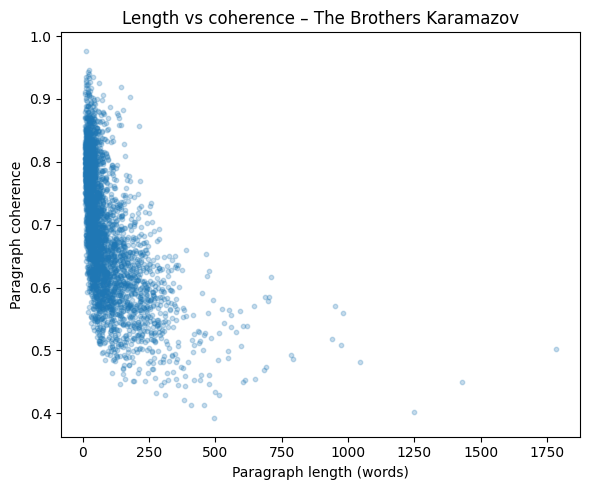

In [7]:
def scatter_length_vs_coherence(lengths, scores, label):
    plt.figure(figsize=(6, 5))
    plt.scatter(lengths, scores, alpha=0.25, s=10)
    plt.xlabel("Paragraph length (words)")
    plt.ylabel("Paragraph coherence")
    plt.title(f"Length vs coherence – {label}")
    plt.tight_layout()
    plt.show()


scatter_length_vs_coherence(c_lengths, c_scores, "Crime and Punishment")
scatter_length_vs_coherence(b_lengths, b_scores, "The Brothers Karamazov")


In [8]:
max_len_idx = brothers_df["length"].idxmax()

print("Index:", max_len_idx)
print("Length:", brothers_df.loc[max_len_idx, "length"])

print("\n=== PARAGRAPH PREVIEW ===\n")
print(brothers_df.loc[max_len_idx, "paragraph"][:1200], "...\n")


Index: 1066
Length: 1785

=== PARAGRAPH PREVIEW ===

“ ‘So that, in truth, Thou didst Thyself lay the foundation for the destruction of Thy kingdom, and no one is more to blame for it. Yet what was offered Thee? There are three powers, three powers alone, able to conquer and to hold captive forever the conscience of these impotent rebels for their happiness﻿—those forces are miracle, mystery and authority. Thou hast rejected all three and hast set the example for doing so. When the wise and dread spirit set Thee on the pinnacle of the temple and said to Thee, “If Thou wouldst know whether Thou art the Son of God then cast Thyself down, for it is written: the angels shall hold him up lest he fall and bruise himself, and Thou shalt know then whether Thou art the Son of God and shalt prove then how great is Thy faith in Thy Father.” But Thou didst refuse and wouldst not cast Thyself down. Oh, of course, Thou didst proudly and well, like God; but the weak, unruly race of men, are they gods

## 4. Character-focused paragraph coherence (Raskolnikov vs others)

The global coherence patterns above mix all types of paragraphs:
description, inner monologue, dialogue, and scenes centred on different characters.

To connect coherence more directly to the **psychological state of specific characters**,
we also compute coherence for paragraphs that strongly feature a given character.

Here we take a simple approach:

- mark paragraphs that contain the name **"Raskolnikov"** (case-insensitive),
- treat these as **Raskolnikov-focused paragraphs**,
- compare their coherence to other paragraphs in the same novel,
- optionally split into *early* vs *late* segments of the book.

This does not capture every mention (e.g. pronouns like "he"), but it gives a first approximation of
how coherence behaves in text segments where Raskolnikov is explicitly foregrounded.


In [9]:
import json

with open("Character Library/Crime_punishment.json", "r", encoding="utf-8") as f:
    crime_chars = json.load(f)

with open("Character Library/The_brothers.json", "r", encoding="utf-8") as f:
    brothers_chars = json.load(f)



In [10]:
print("Crime keys:", crime_chars.keys())
print("Brothers keys:", brothers_chars.keys())



Crime keys: dict_keys(['Rodion_Raskolnikov', 'Sonia_Marmeladov', 'Avdotya_Raskolnikov', 'Arkady_Svidrigailov', 'Dmitri_Razumikhin', 'Pyotr_Luzhin', 'Porfiry_Petrovich', 'Semyon_Marmeladov', 'Katerina_Ivanovna', 'Alyona_Ivanovna', 'Lizaveta_Ivanovna', 'Pulcheria_Alexandrovna', 'Zossimov', 'Alexander_Zametov', 'Andrey_Lebezyatnikov'])
Brothers keys: dict_keys(['Alexei_Karamazov', 'Dmitri_Karamazov', 'Ivan_Karamazov', 'Fyodor_Pavlovich_Karamazov', 'Pavel_Smerdyakov', 'Agrafena_Svetlov', 'Katerina_Ivanovna', 'Father_Zosima', 'Katerina_Khokhlakov', 'Lise_Khokhlakov', 'Mikhail_Rakitin', 'Ilyusha_Snegiryov', 'Nikolai_Snegiryov', 'Pyotr_Miusov'])


In [11]:
def get_alias_list(char_entry: dict):
    """
    From a JSON entry like
    {"aliases": [...], "gender": "M"}
    return a flat list of alias strings in lowercase.
    Some aliases are strings, some are {"text": "...", "tier": ...}.
    """
    names = []
    for a in char_entry["aliases"]:
        if isinstance(a, str):
            names.append(a.lower())
        elif isinstance(a, dict) and "text" in a:
            names.append(a["text"].lower())
    return names


def mark_character_paragraphs(df: pd.DataFrame, name_list):
    lowered = df["paragraph"].str.lower()
    mask = False
    for pat in name_list:
        mask |= lowered.str.contains(pat)
    return mask


# -----------------------------
# CRIME AND PUNISHMENT — Raskolnikov
# -----------------------------
rask_aliases = get_alias_list(crime_chars["Rodion_Raskolnikov"])
crime_df["is_raskolnikov"] = mark_character_paragraphs(crime_df, rask_aliases)
crime_df["segment"] = np.where(crime_df["position_norm"] < 0.5, "early", "late")


# -----------------------------
# BROTHERS KARAMAZOV — Ivan + Alyosha
# -----------------------------
ivan_aliases = get_alias_list(brothers_chars["Ivan_Karamazov"])
alyosha_aliases = get_alias_list(brothers_chars["Alexei_Karamazov"])

brothers_df["is_ivan"] = mark_character_paragraphs(brothers_df, ivan_aliases)
brothers_df["is_alyosha"] = mark_character_paragraphs(brothers_df, alyosha_aliases)
brothers_df["segment"] = np.where(brothers_df["position_norm"] < 0.5, "early", "late")


# -----------------------------
# Quick sanity check
# -----------------------------
crime_df.head(), brothers_df.head()

(                                           paragraph  coherence  length  \
 0  How could a nineteenth-century Russian novel s...   0.713099     178   
 1  fear so much — crimes which themselves spawn c...   0.535082     242   
 2  Literature in the 1840s, he was convicted of s...   0.563174     233   
 3  story of a university dropout, Raskolnikov, wh...   0.644090     234   
 4  the reactions of his friends and family not on...   0.669567     250   
 
                    book  position_norm  is_raskolnikov segment  
 0  Crime and Punishment       0.000000           False   early  
 1  Crime and Punishment       0.001163           False   early  
 2  Crime and Punishment       0.002326            True   early  
 3  Crime and Punishment       0.003488            True   early  
 4  Crime and Punishment       0.004651            True   early  ,
                                            paragraph  coherence  length  \
 0  Alexey Fyodorovitch Karamazov was the third so...   0.667412     

In [13]:
def character_coherence_summary(df, char_col: str, book_label: str):
    summary = (
        df.groupby([char_col, "segment"])["coherence"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    summary["book"] = book_label
    summary["character_flag"] = char_col
    return summary

summary_rask = character_coherence_summary(crime_df, "is_raskolnikov", "Crime and Punishment")
summary_ivan = character_coherence_summary(brothers_df, "is_ivan", "The Brothers Karamazov")
summary_alyosha = character_coherence_summary(brothers_df, "is_alyosha", "The Brothers Karamazov")


In [14]:
# ---------------------------------------
# Merge summary tables for clear display
# ---------------------------------------
summary_all = pd.concat([summary_rask, summary_ivan, summary_alyosha], ignore_index=True)

# Make True/False more readable
summary_all["character_focus"] = summary_all["character_flag"].map({
    "is_raskolnikov": "Raskolnikov",
    "is_ivan": "Ivan Karamazov",
    "is_alyosha": "Alyosha"
})

summary_all["focus?"] = summary_all["character_flag"].map({
    "is_raskolnikov": "Character paragraphs",
    "is_ivan": "Character paragraphs",
    "is_alyosha": "Character paragraphs"
})

# Select useful columns only
clean_summary = summary_all[[
    "book", "character_focus", "focus?", "segment", "mean", "std", "count"
]].sort_values(["book", "character_focus", "segment", "focus?"])

clean_summary


,book,character_focus,focus?,segment,mean,std,count
0,Crime and Punishment,Raskolnikov,Character paragraphs,early,0.542910,0.074793,158
2,Crime and Punishment,Raskolnikov,Character paragraphs,early,0.522740,0.057188,272
1,Crime and Punishment,Raskolnikov,Character paragraphs,late,0.528779,0.081703,176
3,Crime and Punishment,Raskolnikov,Character paragraphs,late,0.523075,0.059447,255
8,The Brothers Karamazov,Alyosha,Character paragraphs,early,0.697781,0.101116,1276
10,The Brothers Karamazov,Alyosha,Character paragraphs,early,0.660362,0.107837,512
9,The Brothers Karamazov,Alyosha,Character paragraphs,late,0.706810,0.098472,1465
11,The Brothers Karamazov,Alyosha,Character paragraphs,late,0.662537,0.108413,323
4,The Brothers Karamazov,Ivan Karamazov,Character paragraphs,early,0.694983,0.103053,1483
6,The Brothers Karamazov,Ivan Karamazov,Character paragraphs,early,0.648571,0.102701,305


<Figure size 600x500 with 0 Axes>

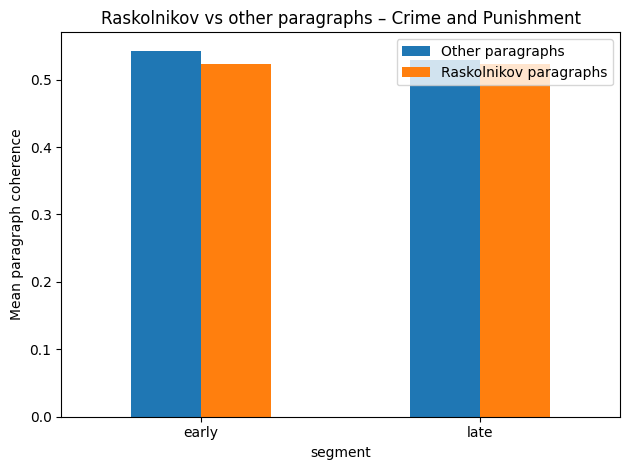

<Figure size 600x500 with 0 Axes>

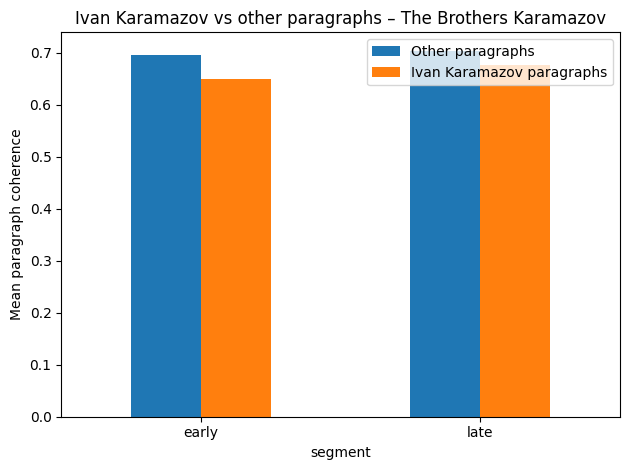

<Figure size 600x500 with 0 Axes>

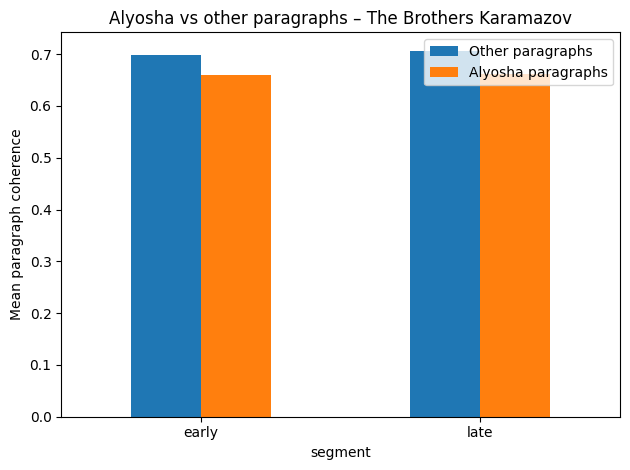

In [15]:
def plot_character_coherence(summary_df, flag_col: str, character_name: str, book_name: str):
    """
    Bar plot of mean paragraph coherence for:
    - paragraphs focused on the character (flag_col == True)
    - all other paragraphs (flag_col == False)
    split into early vs late segments.
    """
    pivot = summary_df.pivot(index="segment", columns=flag_col, values="mean")
    # Columns: False = other paragraphs, True = character-focused

    plt.figure(figsize=(6, 5))
    pivot.plot(kind="bar")
    plt.ylabel("Mean paragraph coherence")
    plt.title(f"{character_name} vs other paragraphs – {book_name}")
    plt.legend(["Other paragraphs", f"{character_name} paragraphs"], title="")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # optional: save figure
    # savefig(f"{character_name.lower().replace(' ', '_')}_coherence_bar")

plot_character_coherence(
    summary_rask,
    flag_col="is_raskolnikov",
    character_name="Raskolnikov",
    book_name="Crime and Punishment",
)

plot_character_coherence(
    summary_ivan,
    flag_col="is_ivan",
    character_name="Ivan Karamazov",
    book_name="The Brothers Karamazov",
)

plot_character_coherence(
    summary_alyosha,
    flag_col="is_alyosha",
    character_name="Alyosha",
    book_name="The Brothers Karamazov",
)


## 5. Notes for interpretation (for the paper draft)

This section is not final text, but a place to collect observations that can later be
turned into sentences in the paper.

Examples of points to check:

- Are global coherence scores lower in the early parts of _Crime and Punishment_ than in later parts?
- Does the smoothed coherence curve show a rise towards the end of the novel?
- Are Raskolnikov-focused paragraphs less coherent than other paragraphs in the **early** half of the book?
- Does their coherence increase in the **late** half, consistent with a move from psychological isolation to engagement?

These observations will later be combined with the emotional-language analyses
(sentiment, character emotion) to address the research question:

> How do emotional language patterns and paragraph-level coherence reflect the psychological transition from isolation to engagement in _Crime and Punishment_ and _The Brothers Karamazov_?


In [16]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Save all current figures
for i in plt.get_fignums():
    fig = plt.figure(i)
    filename = f"figure_{i}.png"
    fig.savefig(os.path.join("figures", filename), dpi=300, bbox_inches="tight")

print("✔ Saved all figures in: figures/")


✔ Saved all figures in: figures/


Results
1. Narrative-Level Coherence Across the Novels

Figure 1 compares the smoothed paragraph coherence of Crime and Punishment and The Brothers Karamazov across their narrative progression (0 = beginning, 1 = ending).
Overall coherence is consistently higher in The Brothers Karamazov, with values fluctuating between 0.66–0.72, whereas Crime and Punishment shows lower coherence, mostly between 0.49–0.56.

The curve for Crime and Punishment is also more unstable, marked by frequent rises and drops. This suggests a stylistic focus on internal oscillation, reflecting the fragmented and distressed cognitive state of Raskolnikov throughout the novel. In contrast, coherence in The Brothers Karamazov remains relatively stable, supporting the novel’s broader thematic structure of familial, ideological, and spiritual interactions rather than a singular psychological focus.

Interpretation: Crime and Punishment presents a more cognitively unstable discourse, aligning with its introspective psychological focus. The Brothers Karamazov maintains stable language coherence due to its multi-perspective, dialogic storytelling.

2. Character-Level Coherence: Isolation vs. Engagement

Figures 2–4 compare the coherence of paragraphs that reference key characters with other paragraphs, split between the first and second halves of the narrative.

Raskolnikov (Crime and Punishment)

Paragraphs referencing Raskolnikov show consistently lower coherence than non-Raskolnikov paragraphs in both halves of the story. The difference persists from early to late segments with only minor changes (≈0.52 → 0.52). His language remains fragmented and internally conflicted, indicating that narrative engagement does not eliminate his unstable cognition, even during confession and resolution.

Interpretation: Raskolnikov does not transition toward cognitive coherence; instead, his moral engagement happens within continuing linguistic instability, reflecting psychological turmoil.

Ivan Karamazov (The Brothers Karamazov)

Ivan-focused paragraphs show lower coherence in the second half compared to the first. This divergence coincides with Ivan’s intensifying philosophical distress and hallucinatory breakdown. Unlike Raskolnikov, Ivan’s coherence decreases over time, suggesting a movement from intellectual control to disorder.

Interpretation: Ivan transitions from rational engagement to destabilized psychological expression, mirrored linguistically.

Alyosha (The Brothers Karamazov)

Alyosha-focused paragraphs remain slightly lower than other paragraphs, but are stable from early to late segments. His sections are driven by dialogue, emotional empathy, and spiritual communication, resulting in less formal coherence without decline.

Interpretation: Alyosha’s discourse is less structurally coherent but consistently dialogic and relational, suggesting steady engagement rather than psychological disturbance.

3. Comparative Interpretation
Character	Coherence Trend	Psychological Movement
Raskolnikov	Stays low	Turbulent engagement within persistent conflict
Ivan Karamazov	Declines	Breakdown under moral-philosophical pressure
Alyosha	Stable, slightly low	Consistent empathetic engagement

Conclusion: Emotional and philosophical engagement is reflected not in uniformly increasing coherence, but in distinct linguistic trajectories shaped by each character’s moral psychology.

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.